In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import run_ring_sim_variable_cfm
print('Libraries imported.')

Libraries imported.


In [5]:
from attack_param_sweep_double_lane import make_benign_driver_list

driver_controller_list = make_benign_driver_list()

print('Driver control list defined.')

sim_res_list = run_ring_sim_variable_cfm(ring_length=600,
    driver_controller_list=driver_controller_list,
    num_lanes=2,
    sim_time=500,
    want_render=False,
    emission_path='data')

print('Simulation finished.')

Driver control list defined.
Number of classes of driver: 80
Running ring simulation, ring length: 600


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 2393.0356089691622
data/ring_variable_cfm_20220624-1113221656087202.2979698-0_emission.csv data
Average, std velocities: 5.482273434244184, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 2393.0356089691622, 0.0
Total time: 104.23827409744263
steps/second: 54.070125709672304
Simulation finished.


In [6]:
import csv

def get_sim_timeseries(csv_path,warmup_period=0.0):
    row_num = 1
    curr_veh_id = 'id'
    sim_dict = {}
    curr_veh_data = []

    with open(csv_path, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        id_index = 0
        time_index = 0
        speed_index = 0
        headway_index = 0
        relvel_index = 0
        edge_index = 0

        row1 = next(csvreader)
        num_entries = len(row1)
        while(row1[id_index]!='id' and id_index<num_entries):id_index +=1
        while(row1[edge_index]!='edge_id' and edge_index<num_entries):edge_index +=1
        while(row1[time_index]!='time' and time_index<num_entries):time_index +=1
        while(row1[speed_index]!='speed' and speed_index<num_entries):speed_index +=1
        while(row1[headway_index]!='headway' and headway_index<num_entries):headway_index +=1
        while(row1[relvel_index]!='leader_rel_speed' and relvel_index<num_entries):relvel_index +=1

        for row in csvreader:
            if(row_num > 1):
                # Don't read header
                if(curr_veh_id != row[id_index]):
                    #Add in new data to the dictionary:

                    #Store old data:
                    if(len(curr_veh_data)>0):
                        sim_dict[curr_veh_id] = np.array(curr_veh_data).astype(float)
                    #Rest where data is being stashed:
                    curr_veh_data = []
                    curr_veh_id = row[id_index] # Set new veh id
                    #Allocate space for storing:
                    # sim_dict[curr_veh_id] = []

                curr_veh_id = row[id_index]
                sim_time = float(row[time_index])
                edge = row[edge_index]
                if(sim_time > warmup_period):
                    # data = [time,speed,headway,leader_rel_speed]
                    data = [row[time_index],row[speed_index],row[headway_index],row[relvel_index]]
                    curr_veh_data.append(data)
            row_num += 1

        #Add the very last vehicle's information:
        sim_dict[curr_veh_id] = np.array(curr_veh_data).astype(float)
        
    print('Data loaded.')
    return sim_dict

In [7]:
warmup_period = 100.0
csv_path_no_attack = sim_res_list[1]     
timeseries_dict_no_attack = get_sim_timeseries(csv_path_no_attack,warmup_period=warmup_period)
print('Bening simulation data extracted.')

Data loaded.
Bening simulation data extracted.


In [8]:
from Detectors.Model_Based.utils import bando_ovm_accel,sim_cfm,sliding_window_spacing_error,get_rec_error_timeseries_dict

accel_func = bando_ovm_accel
seq_len=200
p = [8.86655756,2.09865379,3.01753401,0.67993545,25.1010223]

rec_errors_no_attack = get_rec_error_timeseries_dict(timeseries_dict=timeseries_dict_no_attack,
                                                     seq_len=seq_len,
                                                     accel_func=accel_func,
                                                     p=p,
                                                     dt=0.1)
print('Reconstruction errors extracted.')
                

Reconstruction errors extracted.


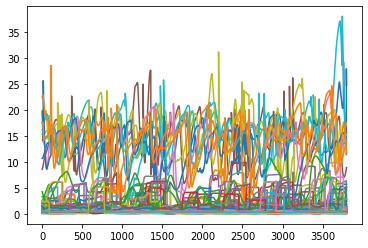

In [9]:
plt.figure()
for veh_id in rec_errors_no_attack:
    plt.plot(rec_errors_no_attack[veh_id])

In [15]:
attack_csv_path = '/Volumes/My Passport for Mac/double_lane_ring_road_attack_parameter_sweep/ring_600m_double_lane_TAD_6.0_ADR_-0.75_ver_10.csv'

timeseries_dict_attack = get_sim_timeseries(attack_csv_path,warmup_period=warmup_period)

Data loaded.


In [18]:
accel_func = bando_ovm_accel
seq_len=200
p = [8.86655756,2.09865379,3.01753401,0.67993545,25.1010223]

rec_errors_attack = get_rec_error_timeseries_dict(timeseries_dict=timeseries_dict_attack,
                                                     seq_len=seq_len,
                                                     accel_func=accel_func,
                                                     p=p,
                                                     dt=0.1)
print('Reconstruction errors for attacked scenario extracted.')

Reconstruction errors for attacked scenario extracted.


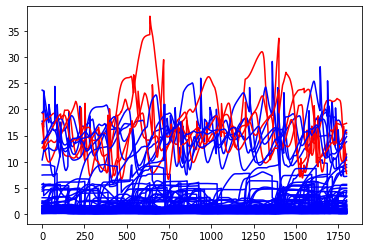

In [20]:
plt.figure()
for veh_id in rec_errors_attack:
    if('adv' in veh_id):
        plt.plot(rec_errors_attack[veh_id],'r')
    else:
        plt.plot(rec_errors_attack[veh_id],'b')

In [ ]:
def get_following_sections(timeseries_dict):
    following_sections = dict.fromkeys(timeseries_dict.keys())
    
    for veh_id in following_sections:
        data = timeseries_dict[veh_id] 
        spacing = data[:,2]
        begin_follow_inidices = []
        end_follow_indices = []
        
        for t in range(1,len(data)):